In [1]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from keras.preprocessing import sequence
from numpy import concatenate

2022-12-22 22:44:42.281906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-22 22:44:43.283315: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-22 22:44:43.283362: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-22 22:44:43.283367: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Загрузим данные для обучения и тестирования из ```keras.datasets.imdb```

Далее сольём данные вместе и разделим в отношении 90/10 на тренировочные и тестовые

Затем обрежем и дополним входные последовательности так, чтобы они были одинаковой длины для моделирования:

In [2]:
from keras.datasets import imdb
import tensorflow.keras.preprocessing.sequence

num_of_words = 10000

(training_data, training_targets), (testing_data, testing_targets) = imdb.load_data(num_words=num_of_words)
data = numpy.concatenate((training_data, testing_data), axis=0)
targets = numpy.concatenate((training_targets, testing_targets), axis=0)

# train [5k:50k]
X_train = data[5000:50000]
Y_train = targets[5000:50000]

# test [:5k]
X_test = data[:5000]
Y_test = targets[:5000]

max_review_length = 500

X_train = tensorflow.keras.preprocessing.sequence.pad_sequences(X_train,maxlen=max_review_length)
X_test = tensorflow.keras.preprocessing.sequence.pad_sequences(X_test,maxlen=max_review_length)

del data
del targets

Введём функции для постройки графиков:

In [3]:
from matplotlib import pyplot as plot

def init_plot(name=''):
    plot.rcParams["figure.figsize"] = (14, 6)
    figure, plot_arr = plot.subplots(2, 2)
    plot_arr[0, 0].set_title("loss")
    plot_arr[0, 1].set_title("accuracy")
    plot_arr[1, 0].set_title("val_loss")
    plot_arr[1, 1].set_title("val_accuracy")
    return plot_arr

def append_to_plot(plot_arr, history, lbl=''):
    plot_arr[0, 0].plot(history.history["loss"], label=lbl)
    plot_arr[0, 1].plot(history.history["accuracy"], label=lbl)
    plot_arr[1, 0].plot(history.history["val_loss"], label=lbl)
    plot_arr[1, 1].plot(history.history["val_accuracy"], label=lbl)

def finalize_plot(plot_arr):
    plot_arr[0, 0].legend()
    plot_arr[0, 1].legend()
    plot_arr[1, 0].legend()
    plot_arr[1, 1].legend()
    plot.show()
plot.clf()

<Figure size 640x480 with 0 Axes>

Модель 1

Архитектура со слоями Embedded, LSTM и Dense с одним выходом:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________


2022-12-22 22:44:53.511206: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-22 22:44:53.511266: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (keesaev-asus-ubuntu): /proc/driver/nvidia/version does not exist
2022-12-22 22:44:53.511740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


None
Epoch 1/3
704/704 [==============================] - 97s 137ms/step - loss: 0.4356 - accuracy: 0.7915 - val_loss: 0.3041 - val_accuracy: 0.8774
Epoch 2/3
704/704 [==============================] - 103s 146ms/step - loss: 0.2474 - accuracy: 0.9026 - val_loss: 0.2758 - val_accuracy: 0.8876
Epoch 3/3
704/704 [==============================] - 108s 153ms/step - loss: 0.1997 - accuracy: 0.9243 - val_loss: 0.2760 - val_accuracy: 0.8914
Accuracy: 89.14%


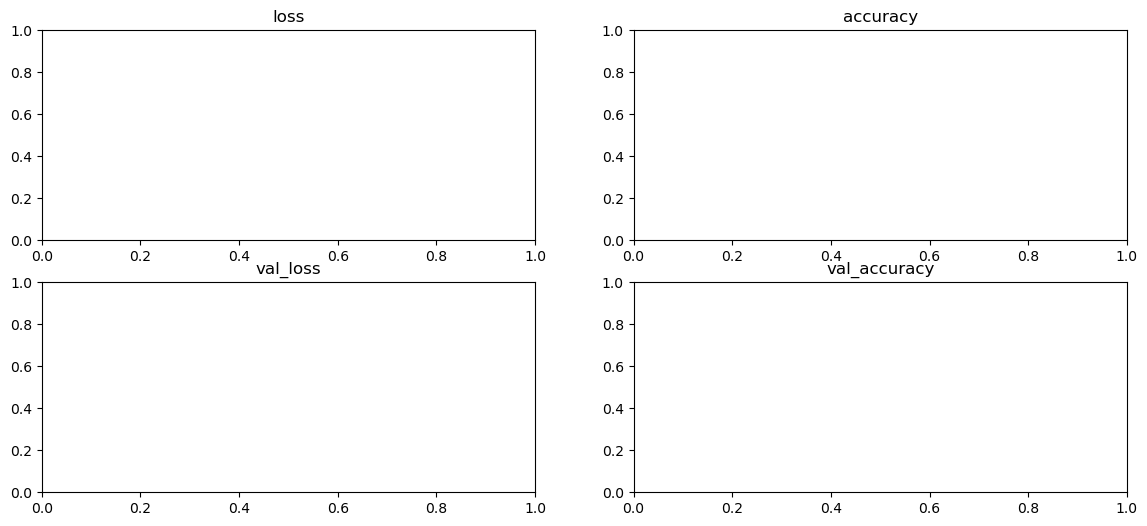

In [4]:
plot_arr = init_plot('Сравнение моделей')

embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(num_of_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
with tensorflow.device("/GPU:0"):
    hist = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3, batch_size=64)
    scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

del model # Эта модель нам не будет нужна

Обучение заняло примерно 4 минуты 43 секунды, в целом модель показала неплохие результаты

Модель 2

В архитектуру добавлен одномерный слой CNN и слой для пулинга с длиной 2, также в слое LSTM число единиц памяти поднимем до 200:

In [5]:
from keras.layers import Conv1D, MaxPooling1D

model2 = Sequential([
    Embedding(num_of_words, embedding_vecor_length, input_length=max_review_length),
    Conv1D(filters=32, kernel_size=3, padding='same',activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(200),
    Dense(1, activation='sigmoid'),
])

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

with tensorflow.device("/GPU:0"):
    hist2 = model2.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3, batch_size=64)
    scores2 = model2.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores2[1]*100))

Epoch 1/3
704/704 [==============================] - 79s 111ms/step - loss: 0.4172 - accuracy: 0.7854 - val_loss: 0.3459 - val_accuracy: 0.8586
Epoch 2/3
704/704 [==============================] - 78s 111ms/step - loss: 0.2229 - accuracy: 0.9146 - val_loss: 0.2529 - val_accuracy: 0.8968
Epoch 3/3
704/704 [==============================] - 78s 111ms/step - loss: 0.1772 - accuracy: 0.9356 - val_loss: 0.2540 - val_accuracy: 0.9010
Accuracy: 90.10%


Сеть показала схожие результаты, однако времени на обучение ушло существенно меньше

Модель 3

Добавим в архитектуру Dropout слои с вероятностью 20% - после пулинга и после LSTM

In [6]:
from keras.layers import Conv1D, MaxPooling1D, Dropout

model3 = Sequential([
    Embedding(num_of_words, embedding_vecor_length, input_length=max_review_length),
    Conv1D(filters=32, kernel_size=3, padding='same',activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(200),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
])

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

with tensorflow.device("/GPU:0"):
    hist3 = model3.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3, batch_size=64)
    scores3 = model3.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores3[1]*100))

Epoch 1/3
704/704 [==============================] - 85s 120ms/step - loss: 0.3989 - accuracy: 0.8128 - val_loss: 0.3306 - val_accuracy: 0.8612
Epoch 2/3
704/704 [==============================] - 85s 121ms/step - loss: 0.2336 - accuracy: 0.9098 - val_loss: 0.2705 - val_accuracy: 0.8896
Epoch 3/3
704/704 [==============================] - 85s 120ms/step - loss: 0.1878 - accuracy: 0.9305 - val_loss: 0.2876 - val_accuracy: 0.8878
Accuracy: 88.78%


Модель 4

Изменим вероятности дропаута - с 20% до 40%:

In [7]:
from keras.layers import Conv1D, MaxPooling1D, Dropout

model4 = Sequential([
    Embedding(num_of_words, embedding_vecor_length, input_length=max_review_length),
    Conv1D(filters=32, kernel_size=3, padding='same',activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    LSTM(200),
    Dropout(0.4),
    Dense(1, activation='sigmoid'),
])

model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

with tensorflow.device("/GPU:0"):
    hist4 = model4.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3, batch_size=64)
    scores4 = model4.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores4[1]*100))

Epoch 1/3
704/704 [==============================] - 86s 120ms/step - loss: 0.4090 - accuracy: 0.8037 - val_loss: 0.2642 - val_accuracy: 0.8970
Epoch 2/3
704/704 [==============================] - 84s 119ms/step - loss: 0.2280 - accuracy: 0.9132 - val_loss: 0.2696 - val_accuracy: 0.8980
Epoch 3/3
704/704 [==============================] - 84s 119ms/step - loss: 0.1813 - accuracy: 0.9334 - val_loss: 0.2682 - val_accuracy: 0.8958
Accuracy: 89.58%


Графики точностей, потерь, а также тестовых точностей и потерь для всех моделей:

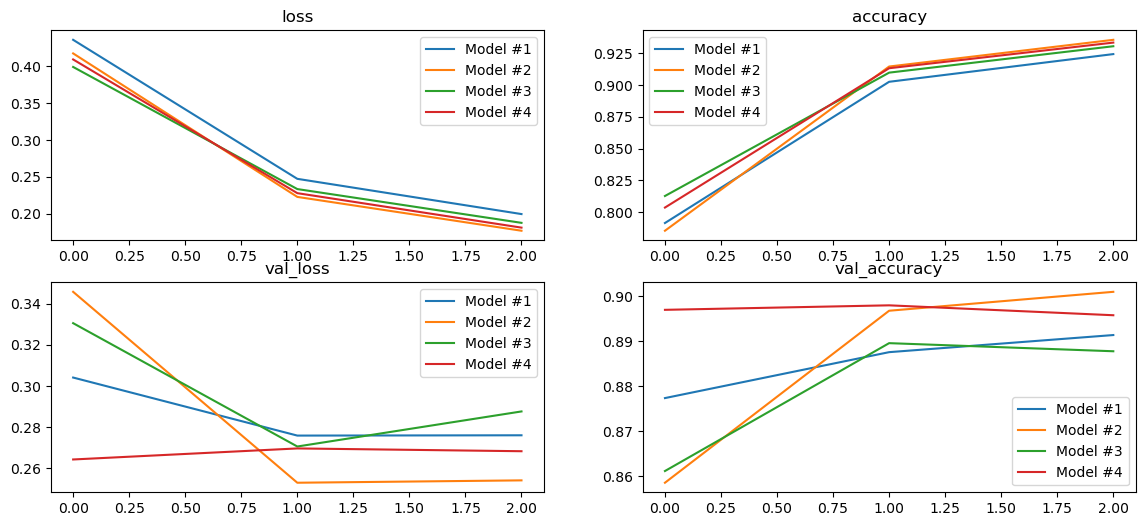

In [8]:
plot_arr = init_plot('Сравнение моделей')
append_to_plot(plot_arr, hist, 'Model #1')
append_to_plot(plot_arr, hist2, 'Model #2')
append_to_plot(plot_arr, hist3, 'Model #3')
append_to_plot(plot_arr, hist4, 'Model #4')

finalize_plot(plot_arr)
plot.show()

Объединим последние 3 модели в ансамбль:

In [9]:
from keras.layers import Input, Average

models = [model2, model3, model4]
model_input = Input(shape=(500))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = tensorflow.keras.Model(inputs=model_input, outputs=ensemble_output)

ensemble_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
scores_ensemble = ensemble_model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores_ensemble[1]*100))

Accuracy: 90.10%


Можно заметить что точность возрасла

Введём функцию для преобразования текста к данным совместимым с keras и попробуем получить предсказания по нескольким отзывам:

In [10]:
from tensorflow import keras

word_index = imdb.get_word_index()
def string_to_data(string, dimensions=10000, max_review_length=500):
  lst = [word_index.get(s, -2)+3 for s in string.lower().split(' ')]
  zer = numpy.zeros(dimensions)
  zer[:len(lst)] = lst
  seq = zer.reshape((1,dimensions))
  return keras.preprocessing.sequence.pad_sequences(seq[:,::-1], maxlen=max_review_length)

print('this movie is awesome', ensemble_model.predict(string_to_data('this movie is awesome'), verbose=0))
print('worst film ever', ensemble_model.predict(string_to_data('worst film ever'), verbose=0))
print('awful', ensemble_model.predict(string_to_data('awful'), verbose=0))
print('best file ever', ensemble_model.predict(string_to_data('best file ever'), verbose=0))


this movie is awesome [[0.8368877]]
worst film ever [[0.12462686]]
awful [[0.14792804]]
best file ever [[0.8038628]]


Вывод:

Лучше всего себя показали модели 2 и 4